In [1]:
import numpy

In [17]:
def read_dict(path):
    dic = set()
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            dic.add(line.strip())
    return dic

# 读取字典：data/词典/pku_training_words.utf8，一行一个词
dic = read_dict('data/词典/pku_training_words.utf8')

# 读取停词表：data/停用词/stop_word.txt，一行一个词
stop_words = read_dict('data/停用词/stop_word.txt')

print('字典大小:', len(dic))
print('停用词大小:', len(stop_words))

字典大小: 55303
停用词大小: 1876


In [3]:
# 读取待分词文本：data/待分词文件/corpus.txt，每行一个句子
with open('data/待分词文件/corpus.txt', 'r', encoding='utf-8') as f:
    text = f.readlines()

print('文本行数:', len(text))
print('文本总字数:', sum(len(line) for line in text))

文本行数: 1945
文本总字数: 174678


In [4]:
import sys
from collections import defaultdict

# 双向最大匹配算法

def cut1_1(text, dic, stop_words): # 前向
    result = []  # 存储分词结果
    max_len = max(len(w) for w in dic)  # 词典中最长词的长度
    i = 0  # 当前扫描位置

    while i < len(text):
        found = False  # 标记是否找到匹配词
        # 从最大长度开始尝试匹配
        for j in range(min(max_len, len(text)-i), 0, -1):
            # 如果当前子串在词典中
            if text[i:i+j] in dic:
                result.append(text[i:i+j])  # 将匹配词加入结果
                i += j  # 移动扫描位置
                found = True  # 标记找到匹配词
                break  # 退出内层循环
        if not found:
            result.append(text[i])  # 如果没有找到匹配词，将当前字符作为单独的词加入结果
            i += 1  # 移动扫描位置
    return result

def cut1_2(text, dic, stop_words): # 后向
    result = []  # 存储分词结果
    max_len = max(len(w) for w in dic)  # 词典中最长词的长度
    i = len(text)  # 当前扫描位置

    while i > 0:
        found = False  # 标记是否找到匹配词
        # 从最大长度开始尝试匹配
        for j in range(min(max_len, i), 0, -1):
            # 如果当前子串在词典中
            if text[i-j:i] in dic:
                result.append(text[i-j:i])  # 将匹配词加入结果
                i -= j  # 移动扫描位置
                found = True  # 标记找到匹配词
                break  # 退出内层循环
        if not found:
            result.append(text[i-1])  # 如果没有找到匹配词，将当前字符作为单独的词加入结果
            i -= 1  # 移动扫描位置
    return result[::-1]

def cut1(text, dic, stop_words):
    result1 = cut1_1(text, dic, stop_words)
    result2 = cut1_2(text, dic, stop_words)
    if len(result1) < len(result2):
        return result1
    elif len(result1) > len(result2):
        return result2
    else:
        return result1 if len(''.join(result1)) < len(''.join(result2)) else result2

In [5]:
# 构建DAG
def build_dag(text, dic):
    dag = defaultdict(list)
    n = len(text)
    for i in range(n):
        for j in range(i + 1, n + 1):
            if text[i:j] in dic:
                dag[i].append(j)
    # 处理单字词
    for i in range(n):
        if len(dag[i]) == 0:
            dag[i].append(i + 1)
    return dag

# 动态规划求最短路径
def shortest_path(text, dag, dic):
    n = len(text)
    dp = [2147483647] * (n + 1)
    dp[0] = 0
    path = [-1] * (n + 1)
    
    for i in range(n):
        for j in dag[i]:
            if dp[i] + 1 < dp[j]:
                dp[j] = dp[i] + 1
                path[j] = i
    
    result = []
    i = n
    while i > 0:
        result.append(text[path[i]:i])
        i = path[i]
    
    result.reverse()

    return result

# 最少分词法（最短路径分词）
def cut2(text, dic, stop_words):
    dag = build_dag(text, dic)
    return shortest_path(text, dag, dic)

In [6]:
with open('output_双向最大匹配.txt', 'w', encoding='utf-8') as f:
    for line in text:
        res1 = cut1(line.strip(), dic, stop_words)
        f.write('  '.join(res1) + '\n')

In [7]:
with open('output_最少分词法.txt', 'w', encoding='utf-8') as f:
    for line in text:
        res2 = cut2(line.strip(), dic, stop_words)
        f.write('  '.join(res2) + '\n')

In [8]:
from sklearn import metrics

In [9]:
# 读取分词标准答案：data/分词对比文件/gold.txt，每行一个句子
with open('data/分词对比文件/gold.txt', 'r', encoding='utf-8') as f:
    gold = f.readlines()

In [10]:

def get_intervals(words):
    intervals = []
    start = 0
    for word in words:
        if word not in stop_words:
            end = start + len(word)
            intervals.append((start, end))
            start = end
        else:
            start += len(word)
    return intervals

def evaluate(result, gold):
    true_intervals = []
    pred_intervals = []
    
    for i in range(len(result)):
        true_intervals.extend(get_intervals(gold[i].strip().split()))
        pred_intervals.extend(get_intervals(result[i].strip().split()))
    
    true_intervals = set(true_intervals)
    pred_intervals = set(pred_intervals)
    
    # Calculate true positives, false positives, and false negatives
    tp = len(true_intervals & pred_intervals)
    fp = len(pred_intervals - true_intervals)
    fn = len(true_intervals - pred_intervals)
    
    # Calculate precision, recall, and F1 score
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    return precision, recall, f1

In [11]:
with open('output_双向最大匹配.txt', 'r', encoding='utf-8') as f:
    result1 = f.readlines()

print('双向最大匹配算法：', evaluate(result1, gold))

双向最大匹配算法： (0.9474548440065681, 0.8599105812220567, 0.9015625)


In [12]:
with open('output_最少分词法.txt', 'r', encoding='utf-8') as f:
    result2 = f.readlines()

print('最少分词法：', evaluate(result2, gold))

最少分词法： (0.9474548440065681, 0.8599105812220567, 0.9015625)


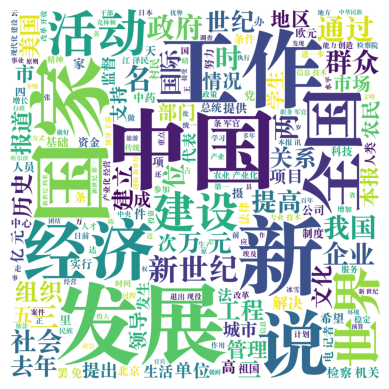

In [18]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

words = []
for line in result2:
    # 滤除停用词
    words.extend([word for word in line.strip().split() if word not in stop_words])

# 生成分词结果
sentences = ""
for word in words:
    if word in stop_words:
        continue
    sentences += str(word) + ' '

# 生成词云
wordcloud = WordCloud(
    background_color='white',
    font_path="/System/Library/Fonts/Supplemental/Songti.ttc",
    width=2000,
    height=2000,
).generate(sentences)

# 输出词云图片
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig("词云")
plt.show()